In [1]:
import os
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge, Input

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## prepare data

In [2]:
def double_integrate(df, col):
    df.sort_values(by='t', inplace=True)
    velocities = df[col].cumsum()
    positions = velocities.cumsum()
    return positions
# load data
def load_data_time(directory = 'data/group3/config_1', all_data=[], labels=[]):
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        data = pd.read_csv(f)
        data['pos_x'] = double_integrate(data,'raw_acceleration_x')
        data['pos_y'] = double_integrate(data,'raw_acceleration_y')
        data['pos_z'] = double_integrate(data,'raw_acceleration_z')
        all_data.append(np.array(data))
        # formatage des labels pour chaque pas de temps
        if directory == 'data/h_config1-lcb':
            _label = int(filename[2])
        elif directory == 'data/v_config1-lcb':
            _label = int(filename[10])
        elif directory == 'data/groupe1_groupe2':
            _label = int(filename.split('_')[1])
        else :
            _label = int(filename[0])
        labels.append(np.array([_label]*len(data)).reshape(-1,1))
    columns_name = pd.read_csv(os.path.join(directory, os.listdir(directory)[1])).columns.tolist()
    return all_data, labels, columns_name

# load horizontal
all_data, labels, _ = load_data_time()
print(len(all_data))
all_data, labels, _ = load_data_time('data/h_config1-lcb',all_data,labels)
print(len(all_data))
# load vertical
all_data, labels, _ = load_data_time('data/v_config1-lcb',all_data,labels)
print(len(all_data))
# # load 3D
# all_data, labels, _ = load_data_time('data/groupe1_groupe2',all_data,labels)
# print(len(all_data))

223
528
831


#### process label 
* we need one hot encoded matrice for classification with reservoirpy
* we need a class for each time_step
* we process before the train_test_split for convenience

In [3]:
enc = OneHotEncoder()
enc.fit_transform(np.array(np.arange(10).reshape(-1,1)))

new_label=[]
for i in range(len(all_data)):
    new_label.append(enc.transform(labels[i]).toarray())#np.tile(enc.transform(labels[i]), (len(all_data[i]), 1)))
print("On transforme les label en one hot encoded:\n",new_label[0][:10])

On transforme les label en one hot encoded:
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


#### train_test_split
* on ne peut pas utiliser sklearn
* train test split with balnaced classes

In [4]:
def train_test_split(all_data, labels, seed_=42):
    np.random.seed(seed_)
    idx_per_class={}
    for i, target in enumerate(labels):
        for j in range(10):
            if j == int(target[0][0]):
                if j not in idx_per_class:
                    idx_per_class[j] = str(i)
                else:
                    idx_per_class[j] = str(idx_per_class[j])+'-'+str(i)

    idx_test=[]
    for t_ in idx_per_class.keys():
        list_idx = idx_per_class[t_].split('-')
        n_test = len(list_idx)//4  # 25% dans le test
        idx_test.append(np.random.choice(list_idx, n_test))

    idx_test = np.concatenate(idx_test).astype(int)
    idx_train = np.array( list(set(np.arange(len(all_data))) - set(idx_test))).astype(int)

    X_train, X_test = [all_data[i] for i in idx_train],  [all_data[i] for i in idx_test] 
    y_train, y_test = [new_label[i] for i in idx_train],  [new_label[i] for i in idx_test]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(all_data, labels, seed_=42)


# reservoir coomputing (the simpliest model)
* https://github.com/reservoirpy/reservoirpy/blob/master/tutorials/5-Classification-with-RC.ipynb


   * lr: the leaking rate, which controls the time constant of the neurons;
   * sr: the spectral radius of the recurrent connections in the reservoir. It controls the chaoticity of the reservoir dynamics.

#### run the model


In [5]:
# on initialize reservoirpy
rpy.verbosity(0) 
rpy.set_seed(42) 

# Simpliest ESN model 
# https://github.com/reservoirpy/reservoirpy/blob/master/tutorials/1-Getting_Started.ipynb
reservoir = Reservoir(500, lr=0.1, sr=0.9)
ridge = Ridge(ridge=1e-6)
esn_model = reservoir >> ridge


# fit & predict
esn_model = esn_model.fit(X_train, y_train, warmup=10)
print("reservoir initialize, ")
print(reservoir.is_initialized, ridge.is_initialized, ridge.fitted)
Y_pred = esn_model.run(X_test)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


#### decode predictions

In [6]:
def make_binary(arr):
    mask = np.zeros(arr.shape)
    mask[np.argmax(arr)] = 1
    return mask

preds = [[make_binary(b) for b in a] for a in Y_pred]

##### on choisi la classe qui à été le plus souvent trouvée

In [7]:
def most_occuring_pred(arr):
    idx = np.argmax(sum(arr))
    mask = np.zeros(arr[0].shape)
    mask[idx] = 1
    mask = mask.reshape(1, -1)
    return enc.inverse_transform(mask)[0]

label_y_pred = [most_occuring_pred([make_binary(b) for b in a]) for a in Y_pred] 
label_y_test = [most_occuring_pred(a) for a in y_test] 

##### on peut visualiser l'evolution des predictions en fonction des timestep

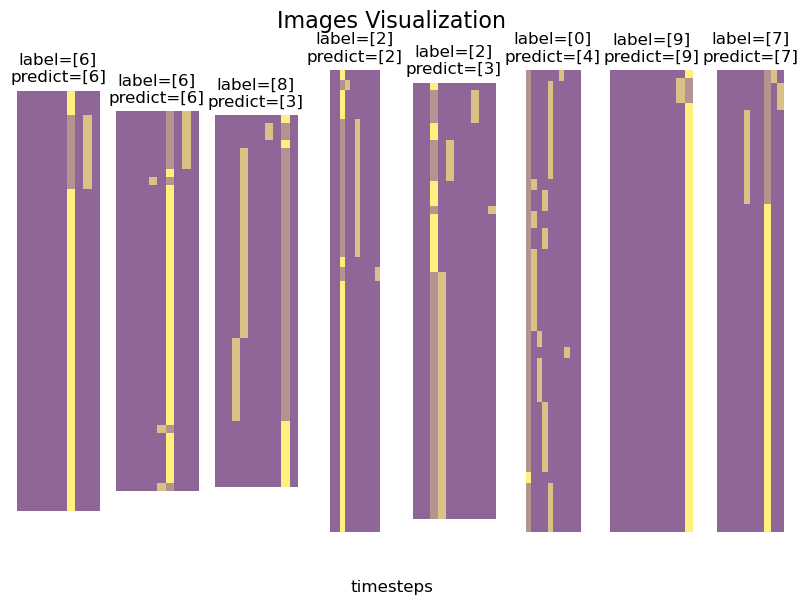

In [8]:
fig, ax = plt.subplots(1, 8, figsize=(10, 6))  
for i, n in enumerate(np.random.choice(len(y_test), 8, replace=False)):
    ax[i].imshow(preds[n],alpha=0.5)#,cmap='jet')
    ax[i].imshow(y_test[n],alpha=0.2)#, cmap='jet')
    #ax[i].imshow(Y_pred[n],alpha=0.5,cmap='jet')
    ax[i].axis('off') 
    ax[i].set_title(f"label={label_y_test[n]}\npredict={label_y_pred[n]}")
fig.suptitle("Images Visualization", fontsize=16)
fig.text(0.5, 0.01, 'timesteps', ha='center', fontsize=12)
plt.show()


accuracy ...  0.6911764705882353
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        20
           1       0.75      0.43      0.55        21
           2       0.76      0.76      0.76        21
           3       0.52      0.63      0.57        19
           4       0.60      0.71      0.65        21
           5       0.55      0.55      0.55        20
           6       0.87      0.65      0.74        20
           7       0.83      0.90      0.86        21
           8       0.70      0.76      0.73        21
           9       0.71      0.75      0.73        20

    accuracy                           0.69       204
   macro avg       0.70      0.69      0.69       204
weighted avg       0.70      0.69      0.69       204



Text(0.5, 1.0, 'Table de contingence')

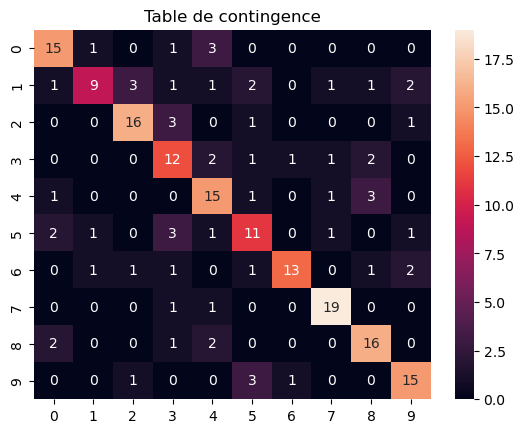

In [9]:
print("accuracy ... ",accuracy_score(label_y_test,label_y_pred))
print(classification_report(label_y_test,label_y_pred))
sns.heatmap(confusion_matrix(label_y_test,label_y_pred), fmt=".2g", annot=True)
plt.title("Table de contingence")

#### methodes tutoriel - accuracy pour chaque pas de temps

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.91844e-26): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


accuracy ...  0.6911764705882353
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1682
           1       0.68      0.49      0.57      1643
           2       0.63      0.68      0.65      1782
           3       0.67      0.53      0.59      1698
           4       0.60      0.61      0.61      1903
           5       0.64      0.61      0.63      1560
           6       0.51      0.56      0.54      1434
           7       0.57      0.75      0.65      1804
           8       0.71      0.73      0.72      2134
           9       0.56      0.55      0.56      1680

    accuracy                           0.64     17320
   macro avg       0.64      0.63      0.63     17320
weighted avg       0.64      0.64      0.63     17320



<Axes: >

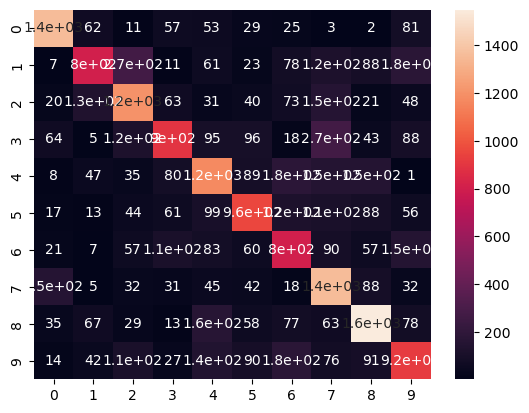

In [10]:
# Transduction (sequence-to-sequence model)
source = Input()
reservoir = Reservoir(500, sr=0.9, lr=0.1)
readout = Ridge(ridge=1e-6)
model = [source >> reservoir, source] >> readout

# fit & predict
Y_pred = model.fit(X_train, y_train, stateful=False, warmup=2).run(X_test, stateful=False)

# decode output
# There are 9 variables(speakers), hence the output space is 9-dimensional. The variable(speaker) label is the index of the output neuron with maximum activation.
Y_pred_class = [np.argmax(y_p, axis=1) for y_p in Y_pred]
Y_test_class = [np.argmax(y_t, axis=1) for y_t in y_test]

score = accuracy_score(np.concatenate(Y_test_class, axis=0), np.concatenate(Y_pred_class, axis=0))

# print("Accuracy: ", f"{score * 100:.3f} %")

print("accuracy ... ",accuracy_score(label_y_test,label_y_pred))
print(classification_report(np.concatenate(Y_test_class, axis=0), np.concatenate(Y_pred_class, axis=0)))
sns.heatmap(confusion_matrix(np.concatenate(Y_test_class, axis=0), np.concatenate(Y_pred_class, axis=0)), fmt=".2g", annot=True)

##### modele tutoriel ([source >> reservoir, source] >> readout) avec most_occuring pred

accuracy ...  0.8137254901960784
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.94      0.81      0.87        21
           2       0.79      0.90      0.84        21
           3       0.86      0.63      0.73        19
           4       0.82      0.67      0.74        21
           5       0.94      0.80      0.86        20
           6       0.79      0.75      0.77        20
           7       0.63      0.90      0.75        21
           8       0.83      0.95      0.89        21
           9       0.79      0.75      0.77        20

    accuracy                           0.81       204
   macro avg       0.83      0.81      0.81       204
weighted avg       0.83      0.81      0.81       204



<Axes: >

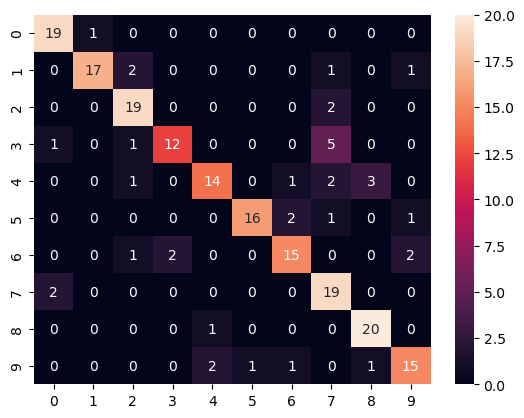

In [11]:
label_y_pred = [most_occuring_pred([make_binary(b) for b in a]) for a in Y_pred] 
label_y_test = [most_occuring_pred(a) for a in y_test] 

print("accuracy ... ",accuracy_score(label_y_test,label_y_pred))
print(classification_report(label_y_test,label_y_pred))
sns.heatmap(confusion_matrix(label_y_test,label_y_pred), fmt=".2g", annot=True)

source = Input()
reservoir = Reservoir(500, sr=0.9, lr=0.1)
readout = Ridge(ridge=1e-6)

model = source >> reservoir >> readout

#### tuning des hyperparametres

In [12]:
from reservoirpy.nodes import Reservoir, Ridge, Input
import time

def explore_hyperparams(param_name='neurons', params_range=[50, 100, 200, 300, 500, 800, 1000, 2000, 3000]):
    results = []
    for param_ in params_range:
        
        source = Input()
        if param_name == 'neurons':
            reservoir = Reservoir(param_, sr=0.9, lr=0.1)
        elif param_name == 'sr':
            reservoir = Reservoir(300, sr=param_, lr=0.1)
        elif param_name == 'lr':
            reservoir = Reservoir(300, sr=0.9, lr=param_)
        else:
            reservoir = Reservoir(300, sr=0.9, lr=0.1)

        readout = Ridge(ridge=1e-6)

        model = [source >> reservoir, source] >> readout   # modele 2 connecte 

        # fit
        t0=time.time()
        model = model.fit(X_train, y_train, stateful=False, warmup=2)
        time_fit = time.time() - t0

        # pred
        Y_pred = model.run(X_test, stateful=False)
        time_pred = time.time()-t0-time_fit
        Y_pred_class = [np.argmax(y_p, axis=1) for y_p in Y_pred]
        Y_test_class = [np.argmax(y_t, axis=1) for y_t in y_test]

        #train score
        Y_pred_train = model.run(X_train, stateful=False)
        Y_pred_train_class = [np.argmax(y_p, axis=1) for y_p in Y_pred_train]
        Y_train_class = [np.argmax(y_t, axis=1) for y_t in y_train]

        score = accuracy_score(np.concatenate(Y_test_class, axis=0), np.concatenate(Y_pred_class, axis=0))
        score_train = accuracy_score(np.concatenate(Y_train_class, axis=0), np.concatenate(Y_pred_train_class, axis=0))
        results.append([param_,score,score_train,time_fit,time_pred])
    return results

# neurons
results = explore_hyperparams(param_name = 'neurons', params_range = [50, 100, 200, 300, 500, 800, 1000, 2000, 3000])


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.70247e-22): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.89471e-22): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.0019e-23): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.0781e-23): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.91421e-26): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.53422e-26): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.30596e-26): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.69784e-27): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.5432e-27): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Text(0.5, 1.0, 'INfluence du nombre de neuronnes dans le réservoir')

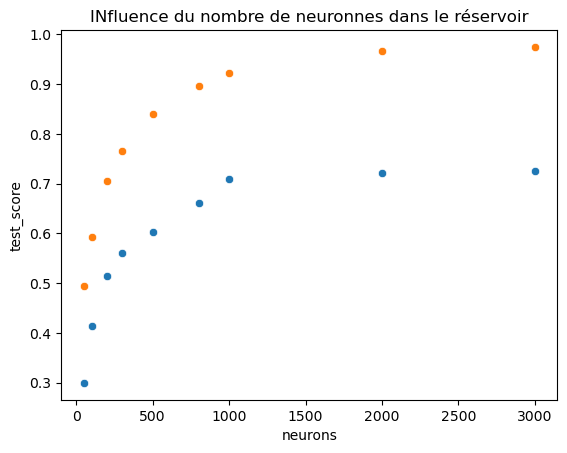

In [13]:
# neurons
res_ = pd.DataFrame(results, columns=['neurons','test_score','score_train','fit_time','pred_time'])

import seaborn as sns
sns.scatterplot(data=res_,x='neurons',y='test_score')
sns.scatterplot(data=res_,x='neurons',y='score_train')
plt.title('INfluence du nombre de neuronnes dans le réservoir')

* Il y a beaucoup de surapprentissage

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.06768e-26): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.45803e-26): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.58893e-26): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.44195e-25): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.76603e-26): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.77545e-24): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.53677e-24): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.91498e-24): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.4384e-26): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.51606e-24): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Text(0.5, 1.0, 'Influence du sr')

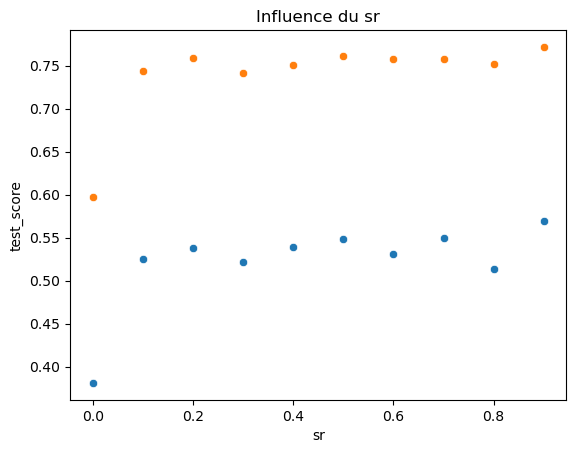

In [14]:
# spectral_radius
results = explore_hyperparams(param_name = 'sr', params_range = np.arange(10)*0.1)

res_ = pd.DataFrame(results, columns=['sr','test_score','score_train','fit_time','pred_time'])

import seaborn as sns
sns.scatterplot(data=res_,x='sr',y='test_score')
sns.scatterplot(data=res_,x='sr',y='score_train')
plt.title('Influence du sr')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.64029e-26): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.61635e-26): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.60972e-24): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.70447e-24): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.55108e-24): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.21317e-22): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Text(0.5, 1.0, 'Influence du lr')

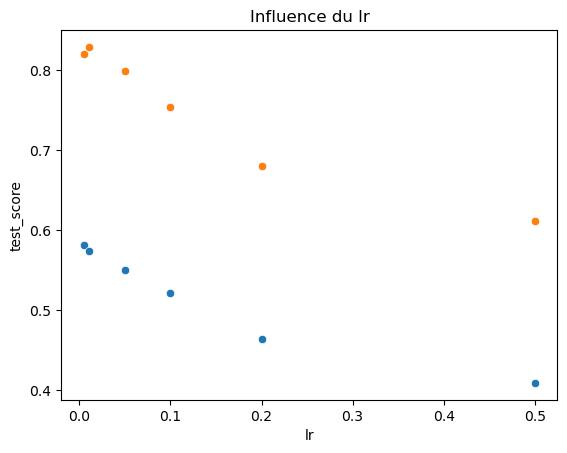

In [15]:
# leak_rate
results = explore_hyperparams(param_name = 'lr', params_range =[0.005, 0.01, 0.05,0.1,0.2,0.5])

res_ = pd.DataFrame(results, columns=['lr','test_score','score_train','fit_time','pred_time'])

import seaborn as sns
sns.scatterplot(data=res_,x='lr',y='test_score')
sns.scatterplot(data=res_,x='lr',y='score_train')
plt.title('Influence du lr')